### Let's find some slightly less shitty models

In [29]:
import numpy as np 
import pandas as pd 
import pandas_profiling

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier


from sklearn.tree import export_graphviz
from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from sklearn.tree import plot_tree

In [30]:
#read in data. csvs in our repo
values_df = pd.read_csv('../../notebooks/training_set_values', index_col=0)
labels_df = pd.read_csv('../../notebooks/training_set_labels', index_col=0)

In [31]:
#merge them together
train_df = pd.merge(labels_df, values_df, on=['id'])
train_df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [32]:
#I want to narrow the data field. 
#Removing duplicates and other columns that I do not think contribute useful data.(see readme)

st_df = train_df[['id', 'status_group', 'amount_tsh','source_class', 
                  'extraction_type_class', 'waterpoint_type_group', 
                  'basin', 'quality_group', 'quantity_group']]
st_df.shape

(59400, 9)

In [33]:
#let's change these objects to categories
st_df.loc[:, ('source_class','extraction_type_class', 'waterpoint_type_group', 
              'basin', 'quality_group', 'quantity_group')].astype('category')

,source_class,extraction_type_class,waterpoint_type_group,basin,quality_group,quantity_group
0,groundwater,gravity,communal standpipe,Lake Nyasa,good,enough
1,surface,gravity,communal standpipe,Lake Victoria,good,insufficient
2,surface,gravity,communal standpipe,Pangani,good,enough
3,groundwater,submersible,communal standpipe,Ruvuma / Southern Coast,good,dry
4,surface,gravity,communal standpipe,Lake Victoria,good,seasonal
...,...,...,...,...,...,...
59395,groundwater,gravity,communal standpipe,Pangani,good,enough
59396,surface,gravity,communal standpipe,Rufiji,good,enough
59397,groundwater,handpump,hand pump,Rufiji,fluoride,enough
59398,groundwater,handpump,hand pump,Rufiji,good,insufficient


In [34]:
#got em?
st_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   source_class           59400 non-null  object 
 4   extraction_type_class  59400 non-null  object 
 5   waterpoint_type_group  59400 non-null  object 
 6   basin                  59400 non-null  object 
 7   quality_group          59400 non-null  object 
 8   quantity_group         59400 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 4.5+ MB


In [40]:
st_df['waterpoint_type_group'].value_counts()

communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64

In [28]:
#st_df.profile_report()

### Got the data. let's play with a model or two...

In [35]:
# throw in all the features from the dataframe

X = st_df.loc[:, ['source_class', 'extraction_type_class', 'waterpoint_type_group',
                  'basin', 'quality_group', 'quantity_group']]
y = st_df.loc[:, 'status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [36]:
#encode the categoricals
ohe = OneHotEncoder(drop='first')

ohe.fit(X_train)
X_train_ohe = ohe.transform(X_train).toarray()

# Creating this DataFrame is not necessary its only to show the result of the ohe
ohe_df = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names(X_train.columns))

ohe_df.head()

,source_class_surface,source_class_unknown,extraction_type_class_handpump,extraction_type_class_motorpump,extraction_type_class_other,extraction_type_class_rope pump,extraction_type_class_submersible,extraction_type_class_wind-powered,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,...,basin_Wami / Ruvu,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_group_enough,quantity_group_insufficient,quantity_group_seasonal,quantity_group_unknown
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [45]:
# going to fit a simple decision tree
clf = DecisionTreeClassifier(criterion='gini', max_depth=3,random_state=42)

clf.fit(X_train_ohe, y_train)

for col, feature in zip(X_train.columns, clf.feature_importances_):
    print(col, feature)


DecisionTreeClassifier(max_depth=3, random_state=42)

In [11]:
y_pred = (clf.predict(X_train_ohe))
recall_score(y_pred, y_train, average='micro')

0.706926406926407

In [12]:
cross_val_score(clf, X_train_ohe, y_train, cv=5)

array([0.70971621, 0.70165945, 0.70887446, 0.71043771, 0.69925445])

In [13]:
print(cross_val_score(clf, X_train_ohe, y_train, cv=5).mean())

0.705988455988456


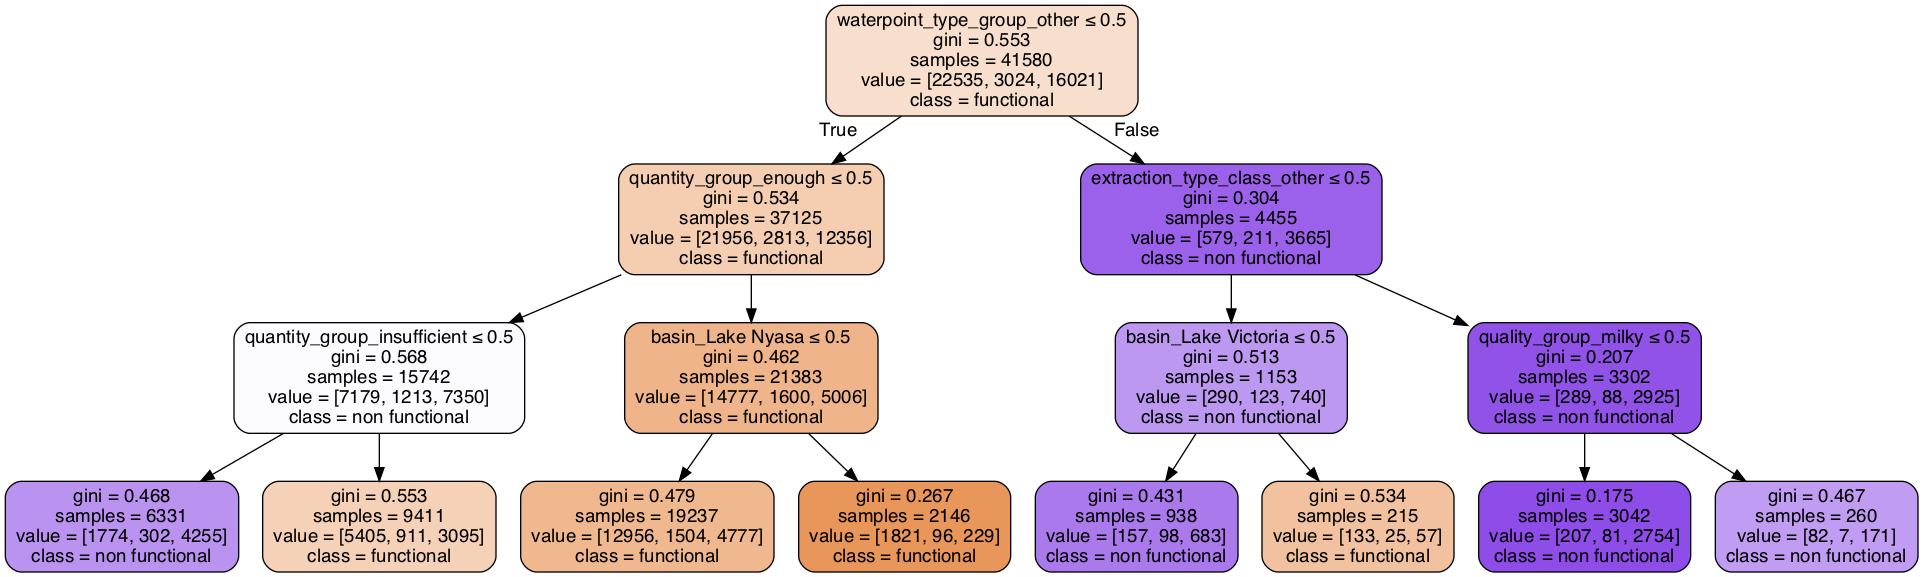

In [46]:
# Create DOT data
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=ohe_df.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [44]:
for col, feature in zip(X_train.columns, clf.feature_importances_):
    print(col, feature)


source_class 0.016061271899044254
extraction_type_class 0.0002647042776007909
waterpoint_type_group 0.01661734256132419
basin 0.009421564357730288
quality_group 0.019014304420166588
quantity_group 0.00023505912721876252


### let's try a Second time with "entropy" instead of "gini"

In [15]:
clf2 = DecisionTreeClassifier(criterion='entropy', random_state=42)

clf2.fit(X_train_ohe, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [16]:
y_pred2 = (clf2.predict(X_train_ohe))
recall_score(y_pred2, y_train, average='micro')

0.7324675324675325

In [18]:
#same value
#try again
clf3 = DecisionTreeClassifier(criterion='entropy', random_state=42)

clf3.fit(X_train_ohe, y_train)
y_pred3 = (clf3.predict(X_train_ohe))
recall_score(y_pred3, y_train, average='micro')

0.7324675324675325

In [19]:
cross_val_score(clf3, X_train_ohe, y_train, cv=5)

array([0.72426647, 0.71897547, 0.72486772, 0.72546898, 0.71007696])

In [20]:
print(cross_val_score(clf3, X_train_ohe, y_train, cv=5).mean())

0.7207311207311208


In [21]:
### Lets go to the forest

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

rfc= RandomForestClassifier(n_estimators=1000, random_state=42)
rfc.fit(X_train_ohe, y_train)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [22]:
y_pred4 = (rfc.predict(X_train_ohe))
recall_score(y_pred4, y_train, average='micro')

0.7324675324675325

In [24]:
bgc = BaggingClassifier(random_state=42)
bgc.fit(X_train_ohe, y_train)

BaggingClassifier(random_state=42)

In [25]:
y_pred5 = (bgc.predict(X_train_ohe))
recall_score(y_pred5, y_train, average='micro')

0.7321789321789322

In [26]:
# Instantiate an AdaBoostClassifier
adaboost_clf = AdaBoostClassifier(random_state=42)

# Instantiate an GradientBoostingClassifier
gbt_clf = GradientBoostingClassifier(random_state=42)


In [27]:
adaboost_clf.fit(X_train_ohe, y_train)

gbt_clf.fit(X_train_ohe, y_train)

GradientBoostingClassifier(random_state=42)

In [48]:
adaboost_train_preds = adaboost_clf.predict(X_train_ohe)
gbt_clf_train_preds = gbt_clf.predict(X_train_ohe)


In [49]:
def display_rec_and_f1_score(true, preds, model_name):
    rec = recall_score(true, preds, average='weighted')
    f1 = f1_score(true, preds, average='weighted')
    print("Model: {}".format(model_name))
    print("Recall: {}".format(rec))
    print("F1-Score: {}".format(f1))
    
print("Training Metrics")
display_rec_and_f1_score(y_train, adaboost_train_preds, model_name='AdaBoost')
print("")
display_rec_and_f1_score(y_train, gbt_clf_train_preds, model_name='Gradient Boosted Trees')
print("")

Training Metrics
Model: AdaBoost
Recall: 0.6976671476671477
F1-Score: 0.6579044046257835

Model: Gradient Boosted Trees
Recall: 0.715993265993266
F1-Score: 0.6768365552737935

